# **ESPIDAM: DQN vs PPO - Practical Implementations**
***Authors: Bram Silue, Prof. dr. Pieter Libin, Prof. dr. Niel Hens.***

### **How to Run**
If you're having trouble running this code on your local machine, please open and run this notebook in Colab:

[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/plibin/espidam-25/blob/main/deep-rl/3_dqn_vs_ppo.ipynb)

We define some helper code that allows this notebook to run in both local environments and Google Colab:

In [ ]:
def is_running_in_colab() -> bool:
    """
    Returns if the code is running inside Google Colab.

    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

### **Introduction**
Previously, we developed a Deep Q-Network (DQN) from scratch to understand the foundational aspects of reinforcement learning algorithms. In practice, however, developers often leverage well-optimized, **pre-built libraries** instead. 

In this notebook, we will use the Stable Baselines library to implement two of the most significant reinforcement learning algorithms: Deep Q-Network (DQN) and Proximal Policy Optimization (PPO). We will train these algorithms on the Lunar Lander environment from Gymnasium. The implementation we will follow is based on the Stable Baselines [documentation](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html).

### **Implementing DQN**
Stable-baselines allows for very straightforward usage of advanced reinforcemente learning algorithms. Let's start with DQN.

First, we import the necessary libraries.

In [ ]:
# Environment.
if is_running_in_colab():
    import subprocess
    subprocess.run(["pip", "install", "swig"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(["pip", "install", "gymnasium"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(["pip", "install", 'gymnasium[box2d]'], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

import gymnasium as gym

# Machine Learning.
if is_running_in_colab():
    subprocess.run(["pip", "install", "stable-baselines3"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback

# Plotting.
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
if is_running_in_colab():
    subprocess.run(["pip", "install", "renderlab"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    import renderlab

# Numerical computing.
import numpy as np

# Other.
import os

# Ignore warnings.
import warnings
warnings.filterwarnings("ignore")

Next, we create the environment and set the random seed.

In [3]:
# Create the environment.
env_name = 'LunarLander-v3' if is_running_in_colab() else 'LunarLander-v2'
env = gym.make(env_name)

# Set the random seed.
SEED = 42
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

[42]

Next, we create the DQN agent.

In [4]:
# Define model with specified parameters.
model = DQN(
    policy='MlpPolicy',
    env=env,
    batch_size=128,
    buffer_size=50_000,
    exploration_final_eps=0.1,
    exploration_fraction=0.12,
    gamma=0.99,
    gradient_steps=-1,
    learning_rate=0.00063,
    learning_starts=0,
    target_update_interval=250,
    train_freq=4,
    seed=SEED,
    policy_kwargs=dict(net_arch=[256, 256])
)

Before training the agent, we write a Callback object that will retrieve the rewards during training so that we can plot the learning curve.

In [ ]:
class LogAndSave_Callback(BaseCallback):
    """
    A custom callback for stable_baselines3 to log cumulative rewards per episode
    and save the best model so far.

    Arguments
    ----------
    save_path :  The file path to save the best model.
    verbose   :  The verbosity level; 0 means silent, higher values increase verbosity.

    """
    def __init__(self, 
                 save_path: str, 
                 verbose: int = 0) -> None:
        """
        Initializes the RewardLoggerCallback instance.

        Arguments
        ---------
        verbose :  Sets the verbosity level; defaults to 0 (silent).

        """
        super(LogAndSave_Callback, self).__init__(verbose)
        self.save_path = save_path

        # Initialize reward logging
        self.all_episode_rewards = []      # list of cumulative rewards, for all episodes.
        self.episode_rewards = 0           # cumulative reward a single episode, initialized at 0.
        self.best_rewards = -float('inf')  # the best reward seen so far, initialized at -inf.

    def _on_step(self) -> bool:
        """
        Executed at each step of the episode to log rewards and reset counters when an episode ends.

        Returns
        -------
        Always returns True to continue training.

        """
        # Accumulate the rewards.
        self.episode_rewards += self.locals['rewards'].item()

        if self.locals['dones']:
            # Log the episode's total reward.
            self.all_episode_rewards.append(self.episode_rewards)
            
            # Save the model if it performs well.
            if self.episode_rewards > 0.9 * self.best_rewards:
                self.model.save(self.save_path)
            
            # Update the best reward.
            if self.episode_rewards > self.best_rewards:
                self.best_rewards = self.episode_rewards

            # Reset accumulated rewards for the next episode.
            self.episode_rewards = 0

        # Return True to continue training.
        return True

Now, we train the DQN agent we just created.

In [ ]:
# Ensure the 'trained' directory exists.
os.makedirs('trained', exist_ok=True)

# Set the arguments.
timesteps = 150_000
callback = LogAndSave_Callback(save_path='trained/dqn.pth')

# Train the model.
model.learn(total_timesteps=timesteps, 
            callback=callback,
            progress_bar=True)

Output()

We can now load the trained DQN model and evaluate it.

In [7]:
# Load the model.
model = DQN.load('trained/dqn.pth', env=env)

# Evaluate the model.
mean_reward, std_reward = evaluate_policy(model=model, 
                                          env=model.get_env(), 
                                          n_eval_episodes=10)
print(f'Mean reward: {mean_reward:.2f} ± {std_reward:.2f}')

Mean reward: 201.54 ± 199.12


Let's also write a plotting function and plot the learning curve.

In [8]:
def plot_learning_curve(model: DQN | PPO,
                        rewards: list, 
                        window_length: int = 15, 
                        polyorder: int = 3) -> None:
    """
    Plots a smoothed learning curve for cumulative rewards from a list.

    Arguments
    ---------
    rewards       :  The list of cumulative rewards per episode.
    window_length :  The length of the filter window.
    polyorder     :  The order of the polynomial used to fit the samples.

    """
    # Convert the rewards list to a numpy array for easier manipulation.
    rewards_array = np.array(rewards)

    # Apply Savitzky-Golay filter to smooth the rewards.
    if len(rewards_array) >= window_length:
        smoothed_rewards = savgol_filter(rewards_array, 
                                         window_length=window_length, 
                                         polyorder=polyorder)
    else:
        # If the data is less than the window length, do not smooth.
        smoothed_rewards = rewards_array

    # Create a new figure for the plot.
    plt.figure()

    # Plot the smoothed cumulative rewards.
    plt.plot(smoothed_rewards, label='Smoothed Cumulative Reward', 
             linewidth=1, color='blue')

    # Configure plot labels and legend.
    plt.xlabel('Episode', fontweight='bold')
    plt.ylabel('Cumulative Reward', fontweight='bold')
    plt.title(f'{model.__class__.__name__}: Smoothed Learning Curve', 
              fontweight='bold')
    plt.legend()
    plt.show()

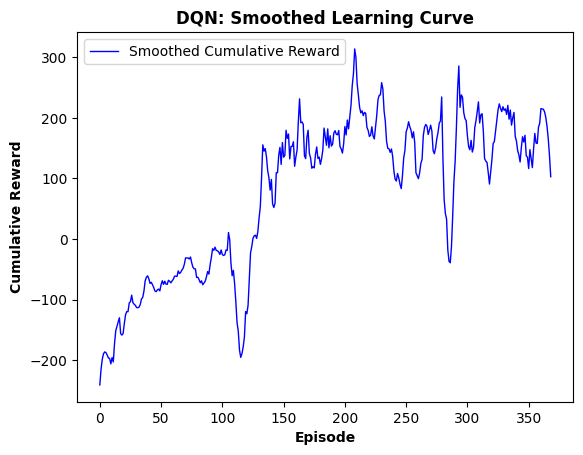

In [9]:
plot_learning_curve(model, rewards=callback.all_episode_rewards)

Finally, we can visualize the policy of our trained DQN model, for fun.

In [10]:
def visualize_policy(model: DQN | PPO, env: gym.Env, seed = 42) -> None:
    """
    Visualizes the policy of a given model via a 2D animation.

    Arguments
    ---------
    model :  The model (DQN or PPO).
    emv   :  The environment.
    seed  :  The random seed.
    
    """
    # In Colab, we must wrap the environment using renderlab to make and store a video later.
    if is_running_in_colab():
        env = renderlab.RenderFrame(env, "./output")

    # Reset the environment, retrieve the state, and set the random seed.
    state, _ = env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    # Simulate.
    while True:
      
        # We employ different rendering methods in Colab vs locally.
        if not is_running_in_colab():
            # Render the frame for visualization.
            env.render()

        # Perform the action.
        action, _ = model.predict(state, deterministic=True)   # compute the model's action.
        state, _, terminated, truncated, _ = env.step(action)  # perform the action.

        # Ccheck if the episode is done.
        if terminated or truncated:
            break

    # Finalize rendering.
    if is_running_in_colab():
        env.play()
    else:
        env.close()

In [11]:
# Create the environment.
env = gym.make(env_name, render_mode='rgb_array' if is_running_in_colab else 'human')

# Set the random seed.
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

[42]

In [12]:
visualize_policy(model, env)

### **Implementing PPO**

We will now use the PPO algorithm from the Stable Baselines library. The approach is analogous to what we did earlier with DQN.

First, we instantiate the environment.

In [13]:
# Create the environment.
env = gym.make(env_name)

# Set the random seed.
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

[42]

Next, we create the PPO agent.

In [14]:
model = PPO(
    policy='MlpPolicy',
    env=env,
    n_steps=512,
    batch_size=128,
    n_epochs=20,
    learning_rate=7.5e-4,
    gamma=0.999,
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.4,
    max_grad_norm=0.7,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=42
)

Next, we train the PPO agent we just created.

In [ ]:
# Set the arguments.
timesteps = 150_000
callback = LogAndSave_Callback(save_path='trained/ppo.pth')

# Train the model.
model.learn(total_timesteps=timesteps, 
            callback=callback,
            progress_bar=True)

Output()

We can now evaluate the PPO agent.

In [16]:
# Load the model.
model = PPO.load('trained/ppo.pth', env=env)

# Evaluate the model.
mean_reward, std_reward = evaluate_policy(model=model, 
                                          env=model.get_env(), 
                                          n_eval_episodes=10)
print(f'Mean reward: {mean_reward:.2f} ± {std_reward:.2f}')

Mean reward: 110.10 ± 137.74


Let's also plot the learning curve.

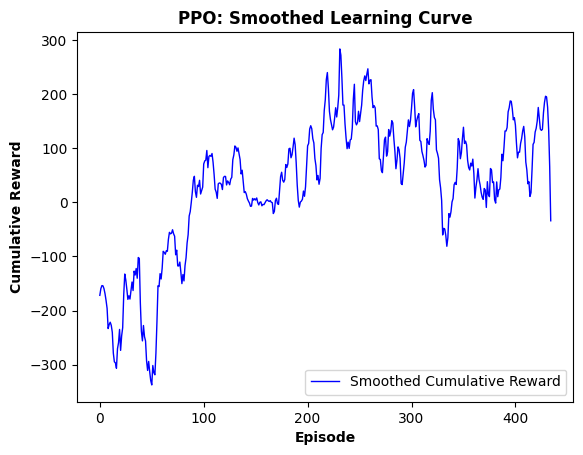

In [17]:
plot_learning_curve(model, rewards=callback.all_episode_rewards)

Finally, we can visualize the policy of our trained PPO agent, for fun.

In [18]:
# Create the environment.
env = gym.make(env_name, render_mode='rgb_array' if is_running_in_colab else 'human')

# Set the random seed.
env.reset(seed=SEED)
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

[42]

In [19]:
visualize_policy(model, env)